# 4. **Flickr30k**

## **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torch.utils.data import DataLoader
import kagglehub
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

## **Download dataset from Kagglehub**

In [ ]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr30k


## **Create custom class to get images and captions from dataset**

In [ ]:
class CustomFlickr30kDataset(Dataset):
    def __init__(self, img_dir, captions_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform


        self.data = pd.read_csv(captions_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['image_name']
        caption = row['comment']

        # Đường dẫn tới ảnh
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, caption


## **Checking for folders and files in the dataset**

In [ ]:
!ls /kaggle/input/flickr30k/
!ls -1 /kaggle/input/flickr30k/flickr30k_images | wc -l
!wc -l /kaggle/input/flickr30k/captions.txt
!du -sh /kaggle/input/flickr30k/

captions.txt  flickr30k_images
31783
158916 /kaggle/input/flickr30k/captions.txt
4.2G	/kaggle/input/flickr30k/


In [ ]:
img_dir = os.path.join(path, "flickr30k_images")
captions_file = os.path.join(path, "captions.txt")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


dataset = CustomFlickr30kDataset(img_dir, captions_file, transform)


## **Sampling some images with their captions**

In [ ]:
from IPython.display import display, HTML
import random
from PIL import Image
import os

In [ ]:
def HTMLDisplay(seed, captions_file):
    random.seed(seed)
    df = pd.read_csv(captions_file)
    img2caps = df.groupby('image_name')['comment'].apply(list).to_dict()
    # print(img2caps)


    sample_images = random.sample(list(img2caps.keys()), 5)
    # sample_images

    html_content = ""

    for img_name in sample_images:
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            continue

        import base64
        from io import BytesIO

        pil_img = Image.open(img_path).resize((300, 300))
        buffered = BytesIO()
        pil_img.save(buffered, format="JPEG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode()

        caption_html = "<ul>" + "".join([f"<li>{cap}</li>" for cap in img2caps[img_name]]) + "</ul>"

        html_content += f"""
        <div style="display: flex; align-items: flex-start; margin: 20px;">
            <img src="data:image/jpeg;base64,{img_base64}" style="width: 300px; height: 300px; margin-right: 20px;" />
            <div>
                <h4>{img_name}</h4>
                {caption_html}
            </div>
        </div>
        """

    return display(HTML(html_content))


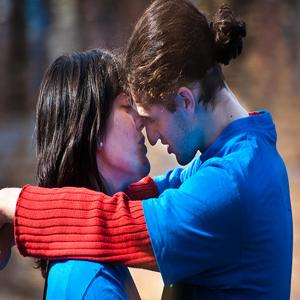
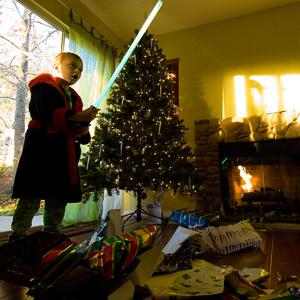
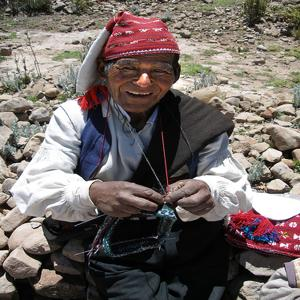
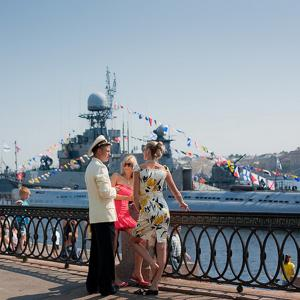
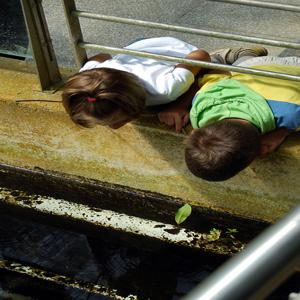

In [ ]:
HTMLDisplay(seed=42, captions_file=captions_file)

# **EDA**

## **Total number of images and captions in the dataset**
* Total images: 31783
* Total captions: 158439
* Average caption per image: 5

In [ ]:
df = pd.read_csv(captions_file)
total_image = df.image_name.nunique()
total_caption = df.comment.nunique()
avg_caption_per_image = total_caption / total_image
print(f"Total images: {total_image}")
print(f"Total captions: {total_caption}")
print(f"Average captions per image: {avg_caption_per_image:.1f}")


Total images: 31783
Total captions: 158439
Average captions per image: 5.0


## **Information in caption file**
* Includes image_name, comment_number and comment columns
* No null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   comment_number  158915 non-null  int64 
 2   comment         158915 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


## **Analyze length of captions**
* The number of words in a caption range from 2-79
* On average, a caption has 13-14 words

In [ ]:
df["caption_length"] = df["comment"].apply(lambda x: len(x.split()))
df.sample(10)
df.caption_length.describe()

,caption_length
count,158915.000000
mean,13.229978
std,5.197936
min,2.000000
25%,10.000000
50%,12.000000
75%,16.000000
max,79.000000


### **Distribution of caption length**
The distribution was skewed to the right with very long right tail

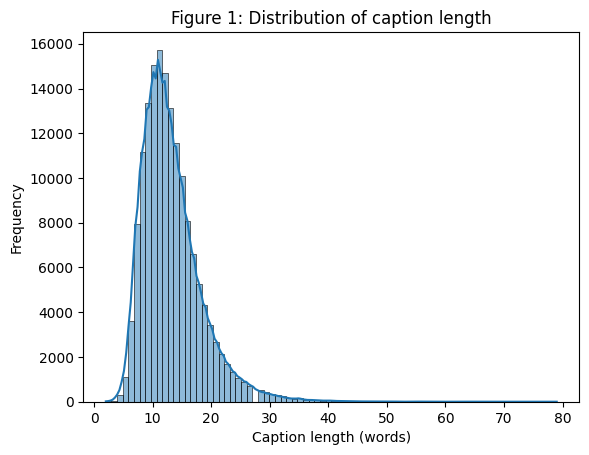

In [ ]:
sns.histplot(df.caption_length, bins=80, kde=True)
plt.title("Figure 1: Distribution of caption length")
plt.xlabel("Caption length (words)")
plt.ylabel("Frequency")
plt.show()

## **Word frequency**
The most common words in caption (after eliminating stopwords) include words for describing genders (male, female, girl, men,...); colors (blue, red, white,...) and actions (standing, sitting, playing,...)

In [ ]:
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


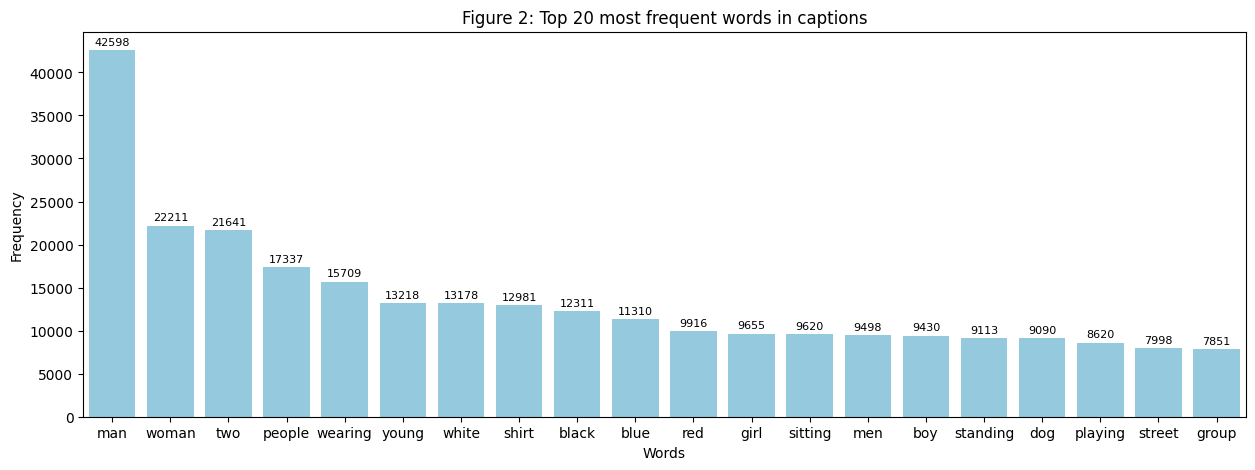

In [ ]:
df['filtered_words'] = df['comment'].apply(lambda x: [
    word.lower() for word in nltk.word_tokenize(x)
    if word.isalpha() and word.lower() not in stop_words
])
all_filtered_words = [word for words in df['filtered_words'] for word in words]
word_freq = Counter(all_filtered_words)

N = 20
plt.figure(figsize=(15, 5))
top_20 = word_freq.most_common(N)
ax = sns.barplot(x=[i[0] for i in top_20], y=[i[1] for i in top_20], color="skyblue")
ax.bar_label(ax.containers[0], fontsize=8, padding=2)
plt.title("Figure 2: Top {} most frequent words in captions".format(N))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


### **Word cloud with word size based on word frequency**

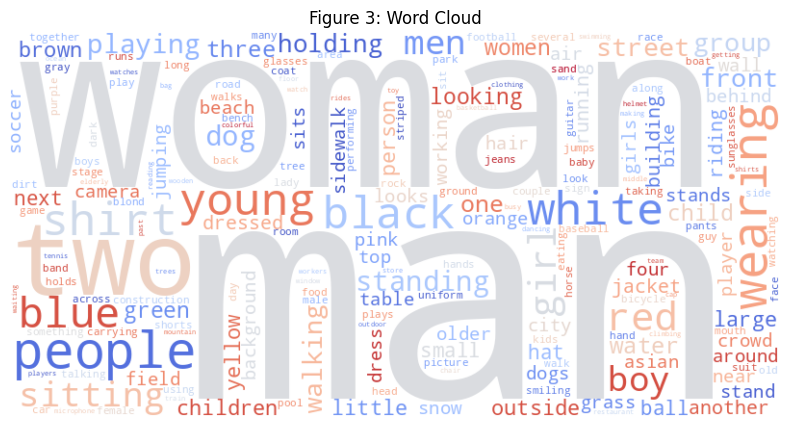

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="coolwarm").generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Figure 3: Word Cloud")
plt.show()

# **Image retrieval using CLIP pre-trained model**
* CLIP (Contrastive Language–Image Pretraining) is a neural network trained on a variety of (image, text) pairs. It is a powerful model that can be used for various tasks such as image-to-text retrieval, text-to-image retrieval (our task), one-shot image classification,...
* CLIP training approach: (Source: [CLIP_approach](https://github.com/openai/CLIP))  
  
<img src="https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/CLIP.png" width="600">

To perform text-to-image task for Flickr30k, the dataset went through feature extraction, then

In [ ]:
# !pip install transformers --quiet
# !pip install torchvision --quiet

import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


## **Choose pretrained model and processor**
* Model: LAION ViT-B/32 (Vision Transformer) from huggingface, based on original OpenAI ViT-B/32 but trained on 2 billions text-image pairs instead of 400 milllions, offering better accuracy and is a little lighter
* Run on GPU if avalable

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K").to(device)
processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
img_dir = os.path.join(path, "flickr30k_images")
df = pd.read_csv(captions_file)
df = df.dropna().reset_index(drop=True)


query_text = "Balloon"


## **Feature embeddings using CLIP**
1. **Images:**
* Put into batch of 32 images for faster processing
* For each image, try to open the image to test availability
* The batches went through CLIP processor and the features were extracted using ``get_image_features``, then returned as tensors
* The tensors were normalized (Euclidean) so that their lengths = 1 to simplify Cosine Similarity in next steps
2. **Texts:**
* The query texts went through CLIP processor and the features were extracted using ``get_image_features``, then returned as tensors
* The tensors were normalized (Euclidean) so that their lengths = 1 to simplify Cosine Similarity in next steps

In [ ]:
image_embeddings = []
image_paths = []
batch_size = 32


for i in tqdm(range(0, len(df), batch_size)):
    batch_df = df.iloc[i:i+batch_size]
    images = []
    for name in batch_df['image_name']:
        img_path = os.path.join(img_dir, name)
        try:
            image = Image.open(img_path).convert("RGB")
            images.append(image)
            image_paths.append(img_path)
        except:
            continue

    inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
        outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)  # Normalize
        image_embeddings.append(outputs.cpu())

image_embeddings = torch.cat(image_embeddings, dim=0)


100%|██████████| 4967/4967 [32:45<00:00,  2.53it/s]


In [ ]:
text_inputs = processor(text=[query_text], return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

## **Image retrieval using Cosine Similarity**
* **Cosine Similarity formula:**  
$
\text{cosine_similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}  
$  
With:
* $ A \cdot B $ is the dot product between two vectors
* ${\|A\| \|B\|}$ is the length of vectors A and B, respectively (Euclidean norm)

In previous steps, I've normalized images and texts vectors into length = 1, therefore Cosine similarity simplified into $ A \cdot B $  
Top k images with highest Cosine Similarity will be printed out

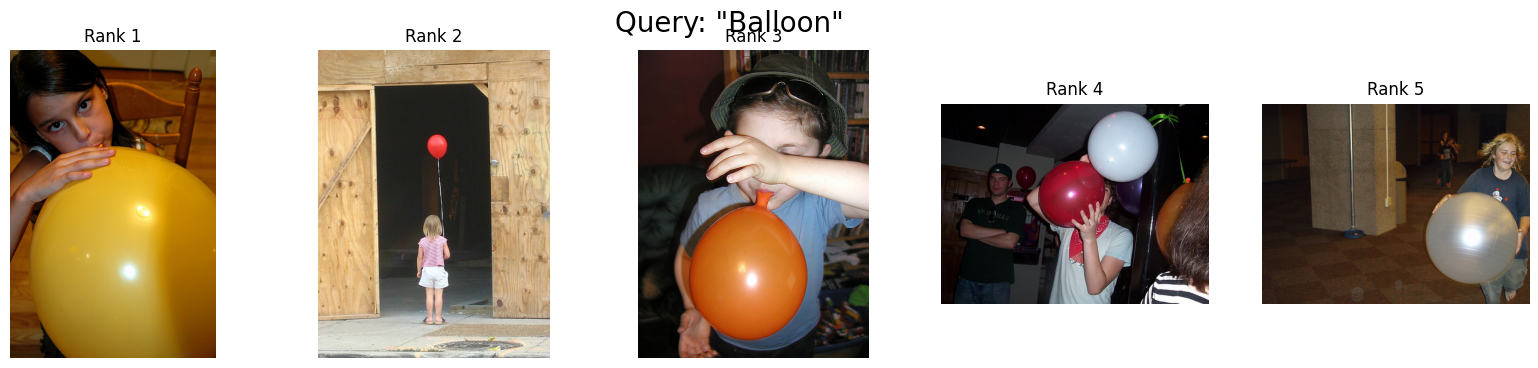

In [ ]:
device = image_embeddings.device
text_features = text_features.to(device)


similarities = (image_embeddings @ text_features.T).squeeze()


top_k = 50
all_indices = similarities.topk(top_k).indices.tolist()


seen = set()
unique_indices = []
for idx in all_indices:
    img_path = image_paths[idx]
    if img_path not in seen:
        seen.add(img_path)
        unique_indices.append(idx)
    if len(unique_indices) == 5:
        break


import math

num_images = len(unique_indices)
cols = min(5, num_images)
rows = math.ceil(num_images / cols)

plt.figure(figsize=(4 * cols, 4 * rows))
for i, idx in enumerate(unique_indices):
    img = Image.open(image_paths[idx])
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Rank {i+1}")

plt.suptitle(f"Query: \"{query_text}\"", fontsize=15)
plt.show()


## **Save results (embeddings and paths) into file for later use**

In [ ]:
save_path = "image_retrieval_data.pth"
torch.save({
    'embeddings': image_embeddings,
    'paths': image_paths
}, save_path)


In [ ]:
load_path = "image_retrieval_data.pth"
data = torch.load(load_path)

image_embeddings = data['embeddings']
image_paths = data['paths']
image_embeddings = image_embeddings.to(device)
# images_paths

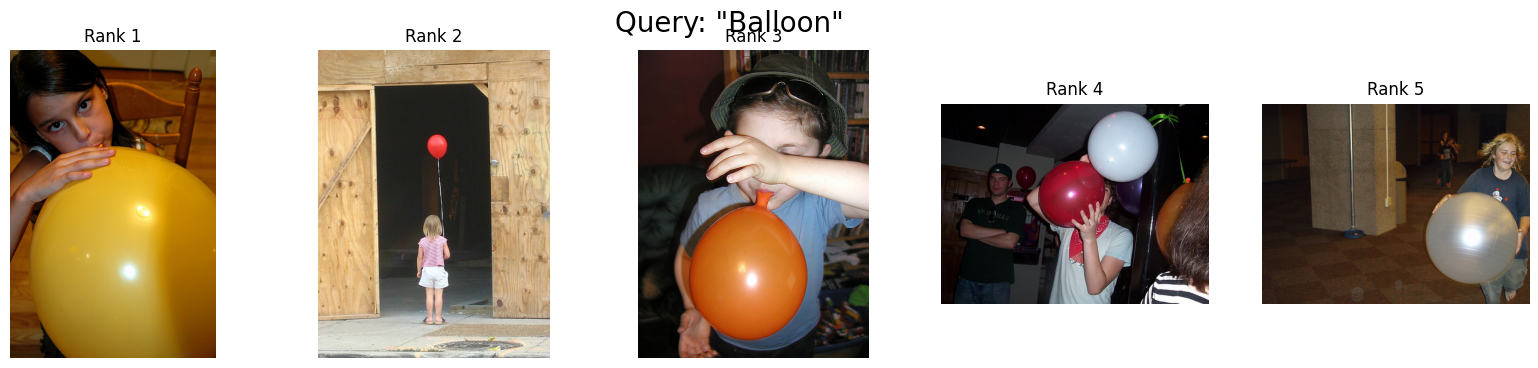

In [ ]:
# text_features = text_features.to(device)

similarities = (image_embeddings @ text_features.T).squeeze()

top_k = 21
all_indices = similarities.topk(top_k).indices.tolist()

# Lọc ảnh trùng lặp
seen = set()
unique_indices = []
for idx in all_indices:
    img_path = image_paths[idx]
    if img_path not in seen:
        seen.add(img_path)
        unique_indices.append(idx)
    if len(unique_indices) == 5:
        break


import math

num_images = len(unique_indices)
cols = min(5, num_images)
rows = math.ceil(num_images / cols)

plt.figure(figsize=(4 * cols, 4 * rows))
for i, idx in enumerate(unique_indices):
    img = Image.open(image_paths[idx])
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Rank {i+1}")

plt.suptitle(f"Query: \"{query_text}\"", fontsize=15)
plt.show()


# **Evaluate model performance using Recall@K**
1. **Recall@K:** Find out if the ground truth image(s) is found in top k images with highest Cosine similarity  
The results after k = [1, 5, 10] showed that:
* **k = 1:** The model was unable to find ground truth image
* **k = 5:** The model found 29% of ground truth images based on the captions
* **k = 10:** The model found 38% of ground truth images based on the captions  
The recall value increased when top k was expanded, but this showed the model's limit in finding the exact ground truth image of a caption. This may due to a few reasons:
* In Flickr30k dataset, the images are quite similar to each other and their captions have words which are also overlapped, making it difficult the map the caption to exact ground truth image
* The choice of CLIP model may not be most suitable for Flickr30k, and fine-tuning may be used to improve recall value.  

## Create captions and captions2image_idx

In [ ]:
captions = []
caption2image_idx = []
image_name_to_idx = {}

for i, path in enumerate(image_paths):
    name = os.path.basename(path)
    image_name_to_idx[name] = i



with open(captions_file, "r") as f:
    for line in f:
        parts = line.strip().split(',', 1)
        if len(parts) != 2:
            continue
        img_caption_id, caption = parts
        img_name = img_caption_id.split("#")[0]

        if img_name in image_name_to_idx:
            captions.append(caption)
            caption2image_idx.append(image_name_to_idx[img_name])

## **Feature extraction for captions in captions.txt**

In [ ]:
text_embeddings = []
batch_size = 32
model = model.to(device)
model.eval()

for i in range(0, len(captions), batch_size):
    batch_texts = captions[i:i+batch_size]
    inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        text_embeddings.append(text_features)

text_embeddings = torch.cat(text_embeddings, dim=0)  # shape: (N_captions, D)


KeyboardInterrupt: 

## K@Recall

In [ ]:
top_k_list = [1, 5, 10]
recall_hits = {k: 0 for k in top_k_list}
precision_hits = {k: 0 for k in top_k_list}
total_samples = 0

image_embeddings = image_embeddings.to(device)

model.eval()

for i in range(0, len(captions), batch_size):
    batch_texts = captions[i:i+batch_size]
    gt_image_idxs = caption2image_idx[i:i+batch_size]  # ground truth image indices

    if not torch.is_tensor(gt_image_idxs):
        gt_image_idxs = torch.tensor(gt_image_idxs)
    gt_image_idxs = gt_image_idxs.to(device)

    inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

        sim = text_features @ image_embeddings.T  # (B, N_images)
        topk_scores, topk_indices = sim.topk(max(top_k_list), dim=1)  # (B, max_k)

    for row, gt_idx in enumerate(gt_image_idxs):
        total_samples += 1
        preds = topk_indices[row]

        for k in top_k_list:
            topk_pred = preds[:k]
            if gt_idx in topk_pred:
                recall_hits[k] += 1

print("==== Evaluation Results ====")
for k in top_k_list:
    recall_k = recall_hits[k] / total_samples
    print(f"Recall@{k}: {recall_k:.4f}")

In [ ]:
top_k_list = [1, 5, 10]
recall_values = [recall_hits[k] / total_samples for k in top_k_list]
precision_values = [precision_hits[k] / total_samples for k in top_k_list]

x = np.arange(len(top_k_list))
width = 0.4

plt.figure(figsize=(8, 5))
plt.bar(x, recall_values, width, label='Recall@K', color='skyblue')

plt.ylabel('Score')
plt.xlabel('K')
plt.title('Figure 4: Model evaluation: Recall@K')
plt.xticks(x, [f'@{k}' for k in top_k_list])
plt.ylim(0, 1.0)
plt.legend()

for i in range(len(x)):
    plt.text(x[i], recall_values[i] + 0.01, f"{recall_values[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()